<a href="https://colab.research.google.com/github/veleronie/WebAttackDetectionModel/blob/main/model_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Network Flow Attack Detection***
Training dataset: [CIC-IDS2017](https://www.unb.ca/cic/datasets/ids-2017.html) (Intrusion Detection Evaluation
Dataset) created by the Canadian Institute for Cybersecurity at the University of New Brunswick. <br>

##***Preprocessing***

In [1]:
import os
import random
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline

path = os.getcwd()
path_to_datasets = path + r'/drive/MyDrive/AnomalyDetection/IDS2017/TrafficLabelling'
all_files = os.listdir(path_to_datasets)    
csv_files = list(filter(lambda f: f.endswith('.csv'), all_files))
csv_files

['Monday-WorkingHours.pcap_ISCX.csv',
 'Wednesday-workingHours.pcap_ISCX.csv',
 'Tuesday-WorkingHours.pcap_ISCX.csv',
 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
 'Friday-WorkingHours-Morning.pcap_ISCX.csv',
 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv']

In [2]:
for i in range(len(csv_files)):
    with open(path_to_datasets + r'/' + csv_files[i], encoding="utf8", errors='ignore') as file:
        df = pd.read_csv(file, low_memory=False)
    df.columns = df.columns.str.strip()
    print(csv_files[i], df.shape)
    print(df['Label'].value_counts(), '\n')

Monday-WorkingHours.pcap_ISCX.csv (529918, 85)
BENIGN    529918
Name: Label, dtype: int64 

Wednesday-workingHours.pcap_ISCX.csv (692703, 85)
BENIGN              440031
DoS Hulk            231073
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name: Label, dtype: int64 

Tuesday-WorkingHours.pcap_ISCX.csv (445909, 85)
BENIGN         432074
FTP-Patator      7938
SSH-Patator      5897
Name: Label, dtype: int64 

Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv (458968, 85)
BENIGN                       168186
Web Attack  Brute Force        1507
Web Attack  XSS                 652
Web Attack  Sql Injection        21
Name: Label, dtype: int64 

Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv (286467, 85)
PortScan    158930
BENIGN      127537
Name: Label, dtype: int64 

Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv (288602, 85)
BENIGN          288566
Infiltration        36
Name: Label, dtype: int64 

Friday-

In order to reduce computational time and resourses, the only class of computer attacks was left to conduct the experements on - web attacks (Brute Force, XSS, SQL injection). For this purpose, there was used a web_attacks file, which was prepared on the basis of processing the file Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv, containing 458968 entries, of which 2180 are related to web attacks, and the rest is labeled as benign traffic.
Each entry in the WebAttacks dataset represents a network session and is characterized by 84 features.

In [3]:
with open(path_to_datasets + r'/' + 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', encoding="utf8", errors='ignore') as file:
      df = pd.read_csv(file, engine='python')
df.columns = df.columns.str.strip()
df.columns

Index(['Flow ID', 'Source IP', 'Source Port', 'Destination IP',
       'Destination Port', 'Protocol', 'Timestamp', 'Flow Duration',
       'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
  

Let's see if the dataset contains NaN values.

In [4]:
df['Flow ID']

0         192.168.10.3-192.168.10.50-389-33898-6
1         192.168.10.3-192.168.10.50-389-33904-6
2                          8.0.6.4-8.6.0.1-0-0-0
3         192.168.10.14-65.55.44.109-59135-443-6
4         192.168.10.3-192.168.10.14-53-59555-17
                           ...                  
458963                                       NaN
458964                                       NaN
458965                                       NaN
458966                                       NaN
458967                                       NaN
Name: Flow ID, Length: 458968, dtype: object

In [5]:
df['Flow ID'].isna().sum()

288602

We need to drop 288602 records with NaN values in the Flow ID column.

In [6]:
df[pd.isnull(df['Flow ID'])].index

Int64Index([170366, 170367, 170368, 170369, 170370, 170371, 170372, 170373,
            170374, 170375,
            ...
            458958, 458959, 458960, 458961, 458962, 458963, 458964, 458965,
            458966, 458967],
           dtype='int64', length=288602)

Seems like there are empty records after the index 170366. We need to remove all of them to continue preprocessing.

In [7]:
df = df.drop(df[pd.isnull(df['Flow ID'])].index)
df.shape

(170366, 85)

Columns 'Fwd Header Length' 'Fwd Header Length.1' have the same data.

In [8]:
df.loc[:, ['Fwd Header Length', 'Fwd Header Length.1' ]] 

,Fwd Header Length,Fwd Header Length.1
0,1536.0,1536.0
1,2176.0,2176.0
2,0.0,0.0
3,192.0,192.0
4,64.0,64.0
...,...,...
170361,20.0,20.0
170362,64.0,64.0
170363,1328.0,1328.0
170364,32.0,32.0


The next step is to remove duplicated columns and clean NaN values.

In [9]:
df = df.drop(columns=['Fwd Header Length.1'])
df.shape

(170366, 84)

In [10]:
df.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.3-192.168.10.50-389-33898-6,192.168.10.50,33898.0,192.168.10.3,389.0,6.0,6/7/2017 8:59,113095465.0,48.0,24.0,...,32.0,203985.500,5.758373e+05,1629110.0,379.0,13800000.0,4.277541e+06,16500000.0,6737603.0,BENIGN
1,192.168.10.3-192.168.10.50-389-33904-6,192.168.10.50,33904.0,192.168.10.3,389.0,6.0,6/7/2017 8:59,113473706.0,68.0,40.0,...,32.0,178326.875,5.034269e+05,1424245.0,325.0,13800000.0,4.229413e+06,16500000.0,6945512.0,BENIGN
2,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0.0,8.0.6.4,0.0,0.0,6/7/2017 8:59,119945515.0,150.0,0.0,...,0.0,6909777.333,1.170000e+07,20400000.0,6.0,24400000.0,2.430000e+07,60100000.0,5702188.0,BENIGN
3,192.168.10.14-65.55.44.109-59135-443-6,192.168.10.14,59135.0,65.55.44.109,443.0,6.0,6/7/2017 8:59,60261928.0,9.0,7.0,...,20.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN
4,192.168.10.3-192.168.10.14-53-59555-17,192.168.10.14,59555.0,192.168.10.3,53.0,17.0,6/7/2017 8:59,269.0,2.0,2.0,...,32.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN


In [11]:
columns_with_missing_values = set(df.columns[df.isnull().any()])
non_numeric_features = list(df.select_dtypes(include=['object']).columns)
for column in columns_with_missing_values:
  if column not in non_numeric_features:
    df[column].fillna(0, inplace = True)
    df.replace([np.inf, -np.inf, np.nan], -1, inplace=True)
df[["Flow Bytes/s", "Flow Packets/s"]] = df[["Flow Bytes/s", "Flow Packets/s"]].apply(pd.to_numeric)
non_numeric_features = list(df.select_dtypes(include=['object']).columns)
non_numeric_features.remove('Label')
non_numeric_features

['Flow ID', 'Source IP', 'Destination IP', 'Timestamp']

In [12]:
df[non_numeric_features]

,Flow ID,Source IP,Destination IP,Timestamp
0,192.168.10.3-192.168.10.50-389-33898-6,192.168.10.50,192.168.10.3,6/7/2017 8:59
1,192.168.10.3-192.168.10.50-389-33904-6,192.168.10.50,192.168.10.3,6/7/2017 8:59
2,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,8.0.6.4,6/7/2017 8:59
3,192.168.10.14-65.55.44.109-59135-443-6,192.168.10.14,65.55.44.109,6/7/2017 8:59
4,192.168.10.3-192.168.10.14-53-59555-17,192.168.10.14,192.168.10.3,6/7/2017 8:59
...,...,...,...,...
170361,157.240.18.35-192.168.10.51-443-55641-6,157.240.18.35,192.168.10.51,6/7/2017 12:59
170362,192.168.10.51-199.16.156.120-45337-443-6,199.16.156.120,192.168.10.51,6/7/2017 12:59
170363,192.168.10.12-192.168.10.50-60148-22-6,192.168.10.12,192.168.10.50,6/7/2017 12:59
170364,192.168.10.12-192.168.10.50-60146-22-6,192.168.10.12,192.168.10.50,6/7/2017 12:59


The next step is to convert string-valued features to numeric with the help of label encoder by scikit-learn library.

In [13]:
df['Label'].value_counts()
labelencoder = preprocessing.LabelEncoder()
df[non_numeric_features] = df[non_numeric_features].apply(lambda column: labelencoder.fit_transform(column))


As it seen above, the data in the dataset is unbalanced: records of benign traffic fill almost the whole dataset.

Benign traffic takes ~98.72% of the dataset.
The solution is to remove a majority of the benign records using undersampling.

Proportion of the following balanced_dataset.csv according to the norm is going to be like this:<br>

30% of the new dataset consists of attacks<br>
70% consists of benign data.<br>

The way to to this: <br>
Records with the attacks are copied to the new dataset.<br>
Conditions for capturing benign records to the new dataset:<br>

    The next record is captured with the benign_prob.

    The total amount of benign records must not 
    go over the limit of 5087 records.


In [14]:
overall_benign = len(df[df['Label'] == "BENIGN"])
overall_attacks = len(df[df['Label'] != "BENIGN"])
print('Benign traffic to attacks ratio: ', overall_benign * 100 / (overall_benign + overall_attacks))

Benign traffic to attacks ratio:  98.72040195813719


In [15]:
ratio_benign_70 = overall_attacks * 70 / 30 
benign_prob = (ratio_benign_70 / overall_benign) * 1.05
print('Benign (70%): {benign}\nAttacks(30%): {attacks}\nProbability value: {prob}'.format(
    benign = ratio_benign_70, attacks = overall_attacks, prob = benign_prob))


Benign (70%): 5086.666666666667
Attacks(30%): 2180
Probability value: 0.03175650767602536


In [16]:
prob_indexes, captured_benign = [], 0
for loc, row in df.iterrows():
    if (row['Label'] == 'BENIGN'):
      if captured_benign < ratio_benign_70:
          if random.random() < benign_prob:
            captured_benign += 1
            prob_indexes.append(loc)
    else:
      prob_indexes.append(loc)
        
balanced_df_30_70 = df.loc[prob_indexes]
balanced_df_30_70.shape


(7267, 84)

In [17]:
balanced_df_30_70.to_csv("balanced.csv", index=False)
df = pd.read_csv('balanced.csv')
print(df['Label'].value_counts())

BENIGN                       5087
Web Attack  Brute Force      1507
Web Attack  XSS               652
Web Attack  Sql Injection      21
Name: Label, dtype: int64


Now that we have a balanced dataset, the goal is to detect wether a record represents an attack or not, so we can encode labels 'BENIGN' with 0 and the other types of traffic are going to be replaced with 1.
Another thing to be mentioned, is that some of the features are not necessary to be taken into consideration when training the model. Such things as ports and addresses can be substituted by an attacker.

In [18]:
df['Label'] = df['Label'].apply(lambda y: 1 if y != 'BENIGN' else 0)
removed = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 
            'Destination Port', 'Protocol', 'Timestamp', 'Init_Win_bytes_backward', 'Init_Win_bytes_forward']
df = df.drop(columns=removed, errors='ignore')

In [19]:
df.shape

(7267, 75)


Calculating feature importance.<br>
First, split the balanced dataset into random train and test subsets.

In [20]:
from sklearn.model_selection import train_test_split
y = df['Label'].values
X = df.drop(columns=['Label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
X.shape, y.shape

((7267, 74), (7267,))

For the convenience of visualization, first we use one tree, choosing only 5 leaves.

By changing the random_state parameter, we will get different trees and different features with the highest importance. But the forest will already average individual trees below.

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
decision_tree = DecisionTreeClassifier(max_leaf_nodes=5, random_state=0)
decision_tree = decision_tree.fit(X_train, y_train)
cross_val_score(decision_tree, X_train, y_train, cv=10)

array([0.95088409, 0.95481336, 0.96463654, 0.95481336, 0.93909627,
       0.95284872, 0.96653543, 0.9507874 , 0.9507874 , 0.97244094])

Suspiciously high scores. The data needs to be observed more carefully, and also it is preferred to see the error matrix.

In [23]:
from sklearn.metrics import confusion_matrix
y_pred = decision_tree.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1514,    1],
       [  68,  598]])

In [24]:
print('ATTACK (train): ', len(y_test[y_test==1]))
print('BENIGN (train):  ', len(y_test[y_test==0]))

ATTACK (train):  666
BENIGN (train):   1515


In [25]:
print('ATTACK : ', len(y_pred[y_pred==1]))
print('BENIGN:  ', len(y_pred[y_pred==0]))

ATTACK :  599
BENIGN:   1582


In [26]:
txt = export_text(decision_tree, feature_names=X_train.columns.to_list())
print(txt)

|--- Packet Length Mean <= 0.75
|   |--- Fwd Header Length <= 100.00
|   |   |--- class: 0
|   |--- Fwd Header Length >  100.00
|   |   |--- Fwd IAT Min <= 13348.00
|   |   |   |--- class: 1
|   |   |--- Fwd IAT Min >  13348.00
|   |   |   |--- class: 0
|--- Packet Length Mean >  0.75
|   |--- Total Length of Fwd Packets <= 34651.50
|   |   |--- class: 0
|   |--- Total Length of Fwd Packets >  34651.50
|   |   |--- class: 1



There are 4 most important features as we can see below.

In [27]:
locs = np.argsort(decision_tree.feature_importances_)[::-1]
for idx, i in enumerate(locs[:20]):
    print("{idx}.\t{feature} - {importance}".format(idx = idx, 
                                                    feature = X_train.columns[i], 
                                                    importance = decision_tree.feature_importances_[i]))

0.	Packet Length Mean - 0.7244642650613947
1.	Fwd Header Length - 0.20074545200364363
2.	Total Length of Fwd Packets - 0.05485746044468535
3.	Fwd IAT Min - 0.019932822490276416
4.	Idle Min - 0.0
5.	Bwd IAT Std - 0.0
6.	Fwd IAT Mean - 0.0
7.	Fwd IAT Std - 0.0
8.	Fwd IAT Max - 0.0
9.	Bwd IAT Total - 0.0
10.	Bwd IAT Mean - 0.0
11.	Bwd IAT Min - 0.0
12.	Bwd IAT Max - 0.0
13.	Flow IAT Min - 0.0
14.	Fwd PSH Flags - 0.0
15.	Bwd PSH Flags - 0.0
16.	Fwd URG Flags - 0.0
17.	Bwd URG Flags - 0.0
18.	Fwd IAT Total - 0.0
19.	Flow IAT Max - 0.0


Using random forest for estimating feature importance.

In [28]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=250, random_state=42, oob_score=True)
random_forest.fit(X_train, y_train)
print('Training Score: {:.4f} \nValidation Score: {:.4f} \nOut-of-bag Score: {:.4f}'.format(
    random_forest.score(X_train, y_train),
    random_forest.score(X_test, y_test), random_forest.oob_score_)
)

Training Score: 0.9880 
Validation Score: 0.9817 
Out-of-bag Score: 0.9740


In [29]:
main_labels = X.columns
imp = random_forest.feature_importances_
idx = np.argsort(imp )[::-1]
web_labels = []
print('{}.\t{}\t{}\t{}'.format('Index', 'Col.', 'Importance', 'Feature'))
for index, column_idx in enumerate(idx[:20]):
    web_labels.append(main_labels[column_idx])
    print('{}.\t{}\t{:.3f}\t{}'.format(index + 1, column_idx, imp[column_idx], main_labels[column_idx]))

Index.	Col.	Importance	Feature
1.	51	0.082	Average Packet Size
2.	13	0.079	Flow Bytes/s
3.	38	0.064	Max Packet Length
4.	39	0.061	Packet Length Mean
5.	7	0.059	Fwd Packet Length Mean
6.	52	0.054	Avg Fwd Segment Size
7.	23	0.052	Fwd IAT Min
8.	61	0.047	Subflow Fwd Bytes
9.	3	0.041	Total Length of Fwd Packets
10.	15	0.036	Flow IAT Mean
11.	33	0.032	Fwd Header Length
12.	5	0.030	Fwd Packet Length Max
13.	21	0.029	Fwd IAT Std
14.	0	0.026	Flow Duration
15.	14	0.025	Flow Packets/s
16.	22	0.019	Fwd IAT Max
17.	35	0.019	Fwd Packets/s
18.	20	0.018	Fwd IAT Mean
19.	16	0.018	Flow IAT Std
20.	19	0.017	Fwd IAT Total


In [30]:
y_pred = random_forest.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1494,   21],
       [  19,  647]])

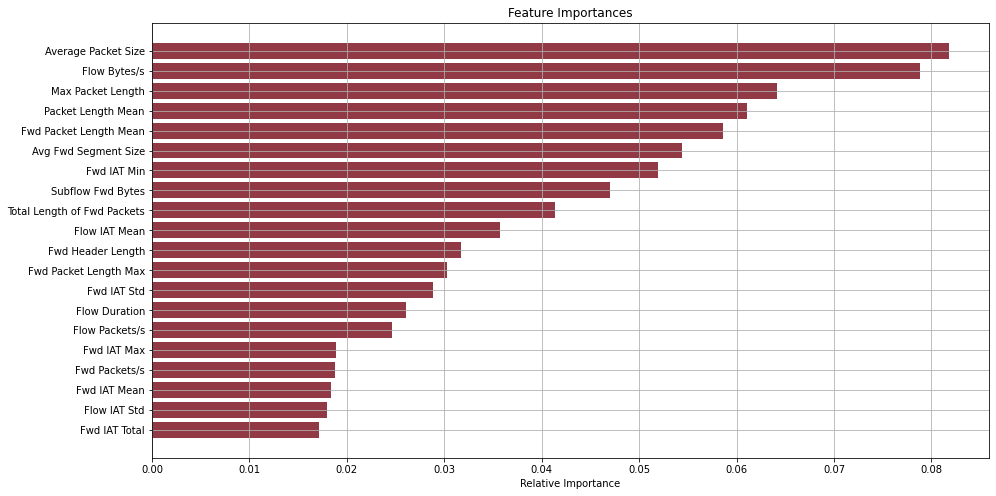

In [31]:
locs = np.argsort(imp)[-20:]
plt.rcParams['figure.figsize'] = (15, 8)
plt.title('Feature Importances')
plt.barh(range(len(locs)), imp[locs], color='#913945', align='center')
plt.yticks(range(len(locs)), [main_labels[i] for i in locs])
plt.xlabel('Relative Importance')
plt.grid()
plt.savefig('feature_importances.png', dpi=300, bbox_inches='tight')
plt.show()


Out of 74 features, we will keep the top 20 important ones.

In [32]:
feature_top = 20
web_labels = web_labels[:feature_top]
web_labels

['Average Packet Size',
 'Flow Bytes/s',
 'Max Packet Length',
 'Packet Length Mean',
 'Fwd Packet Length Mean',
 'Avg Fwd Segment Size',
 'Fwd IAT Min',
 'Subflow Fwd Bytes',
 'Total Length of Fwd Packets',
 'Flow IAT Mean',
 'Fwd Header Length',
 'Fwd Packet Length Max',
 'Fwd IAT Std',
 'Flow Duration',
 'Flow Packets/s',
 'Fwd IAT Max',
 'Fwd Packets/s',
 'Fwd IAT Mean',
 'Flow IAT Std',
 'Fwd IAT Total']

The next step is to check correlation matrix and remove correlated features out of the dataset.

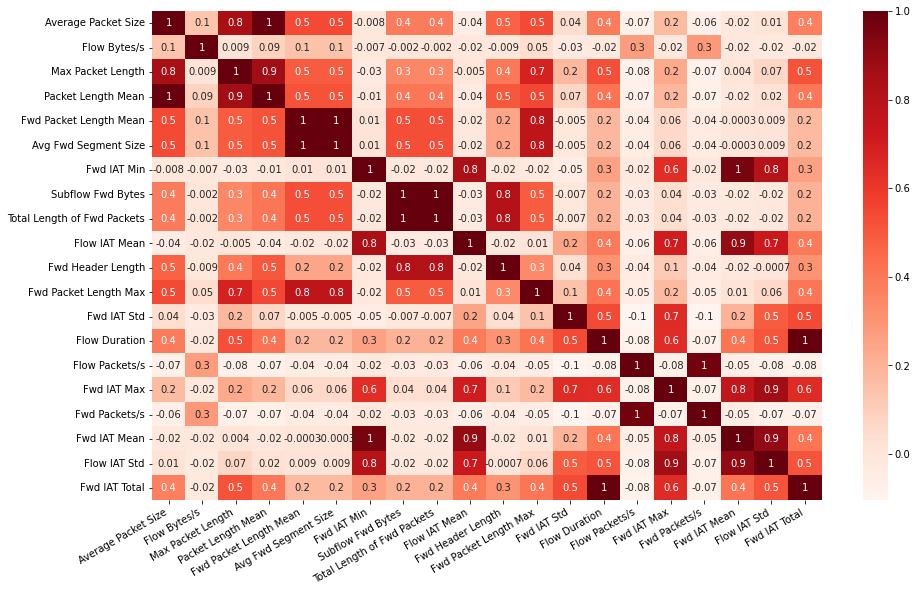

In [33]:
import seaborn as sns
plt.rcParams['figure.figsize'] = (15, 9)
matrix = df[web_labels].corr()
g = sns.heatmap(matrix, annot=True, fmt='.1g', cmap='Reds')
g.set_xticklabels(g.get_xticklabels(), verticalalignment='top', horizontalalignment='right', rotation=30);
plt.savefig('heatmap_correlation.png', dpi=300, bbox_inches='tight')

In [34]:
exl = {'Packet Length Mean', 'Avg Fwd Segment Size', 'Subflow Fwd Bytes',  
        'Fwd Packets/s', 'Fwd IAT Total', 'Fwd IAT Mean'}
web_labels = [item for item in web_labels if item not in exl]
web_labels = web_labels[:10]
web_labels

['Average Packet Size',
 'Flow Bytes/s',
 'Max Packet Length',
 'Fwd Packet Length Mean',
 'Fwd IAT Min',
 'Total Length of Fwd Packets',
 'Flow IAT Mean',
 'Fwd Header Length',
 'Fwd Packet Length Max',
 'Fwd IAT Std']

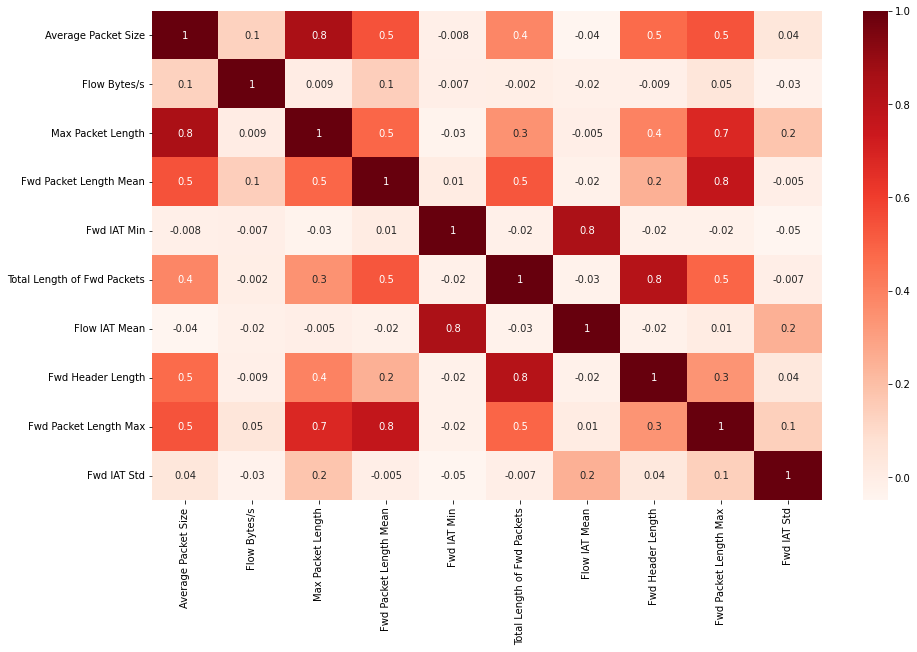

In [35]:
matrix = df[web_labels].corr()
plt.rcParams['figure.figsize'] = (15, 9)
sns.heatmap(matrix, annot=True, fmt='.1g', cmap='Reds')

As a result, now the shape of the dataset is following:

In [36]:
y = df['Label'].values
X = df[web_labels]
print(X.shape, y.shape)

(7267, 10) (7267,)



Now we will choose hyperparameters for the random forrest classifier.

In [37]:
random_forest_classifier = RandomForestClassifier(random_state=1)
random_forest_classifier.get_params().keys()
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators': [10],
              'min_samples_leaf': [3],
              'max_features': [3], 
              'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 17, 20, 30, 50]}
scoring = {'f1', 'accuracy'}
grid_search_cv = GridSearchCV(random_forest_classifier, parameters, 
                              scoring=scoring, refit='f1', cv=10, 
                              return_train_score=True)
get_ipython().run_line_magic('time', 'grid_search_cv.fit(X, y)')
res = grid_search_cv.cv_results_

CPU times: user 12.2 s, sys: 53.5 ms, total: 12.2 s
Wall time: 12.2 s


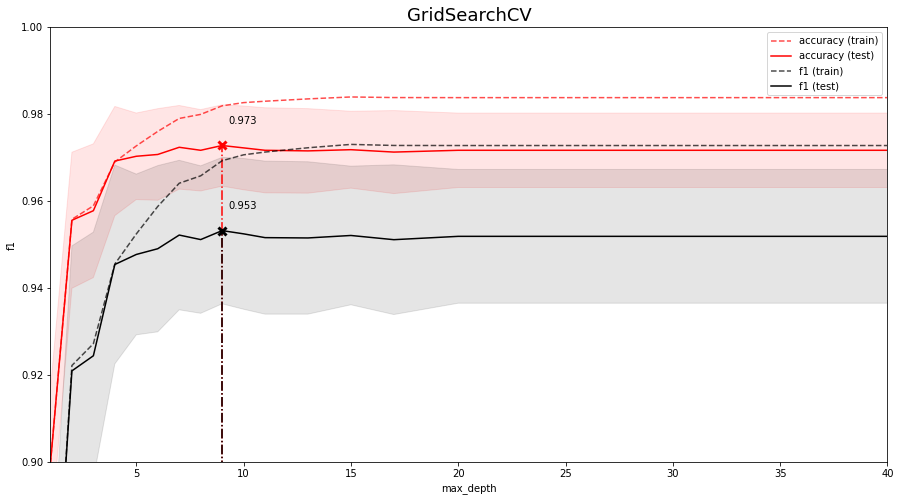

In [38]:
plt.figure(figsize=(15, 8))
plt.title("GridSearchCV", fontsize=18)
plt.xlabel('max_depth')
plt.ylabel('f1')
ax = plt.gca()
ax.set_xlim(1, 40)
ax.set_ylim(0.9, 1)
X_axis = np.array(res['param_max_depth'].data, dtype=float)
for eval, color in zip(sorted(scoring), ['r', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = res['mean_%s_%s' % (sample, eval)]
        sample_score_std = res['std_%s_%s' % (sample, eval)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (eval, sample))
    perfect = np.nonzero(res['rank_test_%s' % eval] == 1)[0][0]
    top_est = res['mean_test_%s' % eval][perfect]
    ax.plot([X_axis[perfect], ] * 2, [0, top_est],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)
    ax.annotate("%0.3f" % top_est,
                (X_axis[perfect] + 0.3, top_est + 0.005))
plt.legend(loc="best")
plt.grid(False)
plt.savefig('GridSearchCV.png', dpi=300)
plt.show()

Choosing the best parameters:

In [39]:
parameters = {
    'max_depth': [10, 17, 23],
    'max_features': [3, 5, 7, 10], 
    'min_samples_leaf': [3, 5, 7],
    'n_estimators': [30, 50, 70],
}
grid_search_cv = GridSearchCV(random_forest_classifier, parameters, scoring=scoring, refit='f1', cv=3, return_train_score=True)
get_ipython().run_line_magic('time', 'grid_search_cv.fit(X, y)')

CPU times: user 2min 6s, sys: 388 ms, total: 2min 7s
Wall time: 2min 7s


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [10, 17, 23],
                         'max_features': [3, 5, 7, 10],
                         'min_samples_leaf': [3, 5, 7],
                         'n_estimators': [30, 50, 70]},
             refit='f1', return_train_score=True, scoring={'f1', 'accuracy'})

The best parameters for the classifier are:

In [40]:
grid_search_cv.best_estimator_

RandomForestClassifier(max_depth=10, max_features=3, min_samples_leaf=3,
                       n_estimators=30, random_state=1)

In [41]:
grid_search_cv.best_score_

0.9500285918196365

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
random_forest_classifier = RandomForestClassifier(max_depth=10, max_features=10, 
                                                  min_samples_leaf=3, n_estimators=70, random_state=1,
                                                  oob_score=True)
random_forest_classifier.fit(X_train, y_train)

(5086, 10) (5086,)
(2181, 10) (2181,)


RandomForestClassifier(max_depth=10, max_features=10, min_samples_leaf=3,
                       n_estimators=70, oob_score=True, random_state=1)

In [43]:
attrs = X.columns
imp = random_forest_classifier.feature_importances_
locs = np.argsort(imp)[::-1]
for idx, col_num in enumerate(locs[:10]):
    print('{}.\t#{}\t{:.3f}\t{}'.format(idx + 1, col_num, imp[col_num], attrs[col_num]))
y_pred = random_forest_classifier.predict(X_test)
print('Confusion Matrix:\t\n', confusion_matrix(y_test, y_pred))

1.	#0	0.329	Average Packet Size
2.	#2	0.301	Max Packet Length
3.	#7	0.108	Fwd Header Length
4.	#9	0.078	Fwd IAT Std
5.	#4	0.052	Fwd IAT Min
6.	#6	0.048	Flow IAT Mean
7.	#5	0.047	Total Length of Fwd Packets
8.	#3	0.019	Fwd Packet Length Mean
9.	#1	0.011	Flow Bytes/s
10.	#8	0.008	Fwd Packet Length Max
Confusion Matrix:	
 [[1492   23]
 [  25  641]]


In [44]:
import sklearn.metrics as metrics

acc_score = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)

print('Accuracy:\t', acc_score)
print('Precision:\t', prec)
print('Recall:\t', recall)
print('F1:\t', f1)


Accuracy:	 0.9779917469050894
Precision:	 0.9653614457831325
Recall:	 0.9624624624624625
F1:	 0.9639097744360903


In [45]:
with open('model.pkl', 'wb') as file:
    pickle.dump(random_forest_classifier, file)
with open('model.pkl', 'rb') as file:
    random_forest_classifier = pickle.load(file)
random_forest_classifier

RandomForestClassifier(max_depth=10, max_features=10, min_samples_leaf=3,
                       n_estimators=70, oob_score=True, random_state=1)

In [50]:
df = pd.read_csv('balanced.csv')
df['Label'] = df['Label'].apply(lambda y: 1 if y != 'BENIGN' else 0)
y_test = df['Label'].values
X_test = df[web_labels]
print(X_test.shape, y_test.shape)
print("Benign traffic actual:\t{b} \nAttacks actual:\t{a}".format(b = len(y_test[y_test == 0]),
                                                                  a = len(y_test[y_test == 1])))

(7267, 10) (7267,)
Benign traffic actual:	5087 
Attacks actual:	2180


In [51]:
import time
seconds = time.time()
y_pred = random_forest_classifier.predict(X_test)
print("Time of the operation:\t", time.time() - seconds, "seconds")
print("Benign traffic:\t{b} \nAttacks detected:\t{a}".format(b = len(y_pred[y_pred == 0]),
                                                             a = len(y_pred[y_pred == 1])))

Time of the operation:	 0.11400794982910156 seconds
Benign traffic:	5112 
Attacks detected:	2155


In [52]:
print("Benign traffic actual:\t{b} \nAttacks actual:\t{a}".format(b = len(y_test[y_test == 0]),
                                                                  a = len(y_test[y_test == 1])))

Benign traffic actual:	5087 
Attacks actual:	2180


In [53]:
confusion_matrix(y_test, y_pred)

array([[5033,   54],
       [  79, 2101]])

In [54]:
import sklearn.metrics as metrics

acc_score = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)

print('Accuracy:\t', acc_score)
print('Precision:\t', prec)
print('Recall:\t', recall)
print('F1:\t', f1)

Accuracy:	 0.9816980872437044
Precision:	 0.9749419953596288
Recall:	 0.9637614678899082
F1:	 0.9693194925028835


In [60]:
res[380:480]

,Average Packet Size,Flow Bytes/s,Max Packet Length,Fwd Packet Length Mean,Fwd IAT Min,Total Length of Fwd Packets,Flow IAT Mean,Fwd Header Length,Fwd Packet Length Max,Fwd IAT Std,Label,Predict
380,9.000000,2.488594e+03,6.0,6.000000,4822.0,12.0,4.822000e+03,40.0,6.0,0.000000e+00,0,0
381,2.000000,3.653806e+00,6.0,2.000000,23467.0,6.0,6.568494e+05,84.0,6.0,8.561677e+05,0,0
382,22.666667,6.607143e+05,31.0,15.500000,4.0,31.0,2.800000e+01,64.0,31.0,0.000000e+00,0,0
383,238.785714,6.447298e+02,1047.0,146.000000,4.0,1022.0,3.988552e+05,232.0,372.0,5.614102e+04,1,1
384,624.470588,2.099113e+03,4344.0,73.600000,192.0,736.0,3.160859e+05,328.0,395.0,1.650529e+06,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
475,144.222222,7.596656e+00,404.0,85.666667,64687.0,514.0,1.470000e+07,120.0,404.0,3.210000e+07,0,0
476,9.000000,4.000000e+06,6.0,6.000000,3.0,12.0,3.000000e+00,40.0,6.0,0.000000e+00,0,0
477,77.333333,5.565018e+03,142.0,36.000000,3.0,144.0,1.538180e+04,80.0,36.0,1.751912e+04,0,0
478,98.666667,8.847535e+03,171.0,50.000000,3.0,200.0,1.225200e+04,80.0,50.0,1.779971e+04,0,0


There are 133 records out of 7267 which where guessed wrong

In [55]:
predict = pd.DataFrame({'Predict': random_forest_classifier.predict(X_test)})
label = pd.DataFrame({'Label': y_test})
res = X_test.join(label).join(predict)
res[res['Predict'] != res['Label']]

,Average Packet Size,Flow Bytes/s,Max Packet Length,Fwd Packet Length Mean,Fwd IAT Min,Total Length of Fwd Packets,Flow IAT Mean,Fwd Header Length,Fwd Packet Length Max,Fwd IAT Std,Label,Predict
186,0.000000,0.000000,0.0,0.0,0.0,0.0,91.0000,32.0,0.0,0.000000e+00,0,1
373,0.000000,0.000000,0.0,0.0,0.0,0.0,50.0000,32.0,0.0,0.000000e+00,0,1
384,624.470588,2099.113097,4344.0,73.6,192.0,736.0,316085.8750,328.0,395.0,1.650529e+06,1,0
432,0.000000,0.000000,0.0,0.0,0.0,0.0,35.0000,32.0,0.0,0.000000e+00,0,1
459,140.125000,220.306263,763.0,89.5,4.0,358.0,726910.1429,136.0,358.0,4.872589e+04,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6923,0.000000,0.000000,0.0,0.0,0.0,0.0,50.0000,32.0,0.0,0.000000e+00,0,1
7058,0.000000,0.000000,0.0,0.0,0.0,0.0,93.0000,32.0,0.0,0.000000e+00,0,1
7062,0.000000,0.000000,0.0,0.0,0.0,0.0,35.0000,32.0,0.0,0.000000e+00,0,1
7174,0.000000,0.000000,0.0,0.0,0.0,0.0,81.0000,32.0,0.0,0.000000e+00,0,1
